## DALL-E Image Generation from OpenAI ##

In [32]:
#imports
import os
import base64
from io import BytesIO
from PIL import Image
from dotenv import load_dotenv
from openai import OpenAI
import gradio as gr


c:\Python\llm_engineering\llms\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Loads environment variables in hidden .env file
load_dotenv()
openai_api_key = os.getenv('OPENAI_API_KEY') #OPENAI_API_KEY is in Path variable on local machine

#Connect
openai = OpenAI()


Images are way more costly! Be careful generating

In [3]:
def artist(city):
    image_response = openai.images.generate(
        model = 'dall-e-3',
        prompt = f"An image representing a vacation paradise in {city}, showing tourist spots, including some unique things about {city} in a vibrant pop-up style ",
        size = "1024x1024",
        n=1,
        response_format="b64_json"
    )
    image_base64 = image_response.data[0].b64_json
    image_data = base64.b64decode(image_base64)
    return Image.open(BytesIO(image_data))

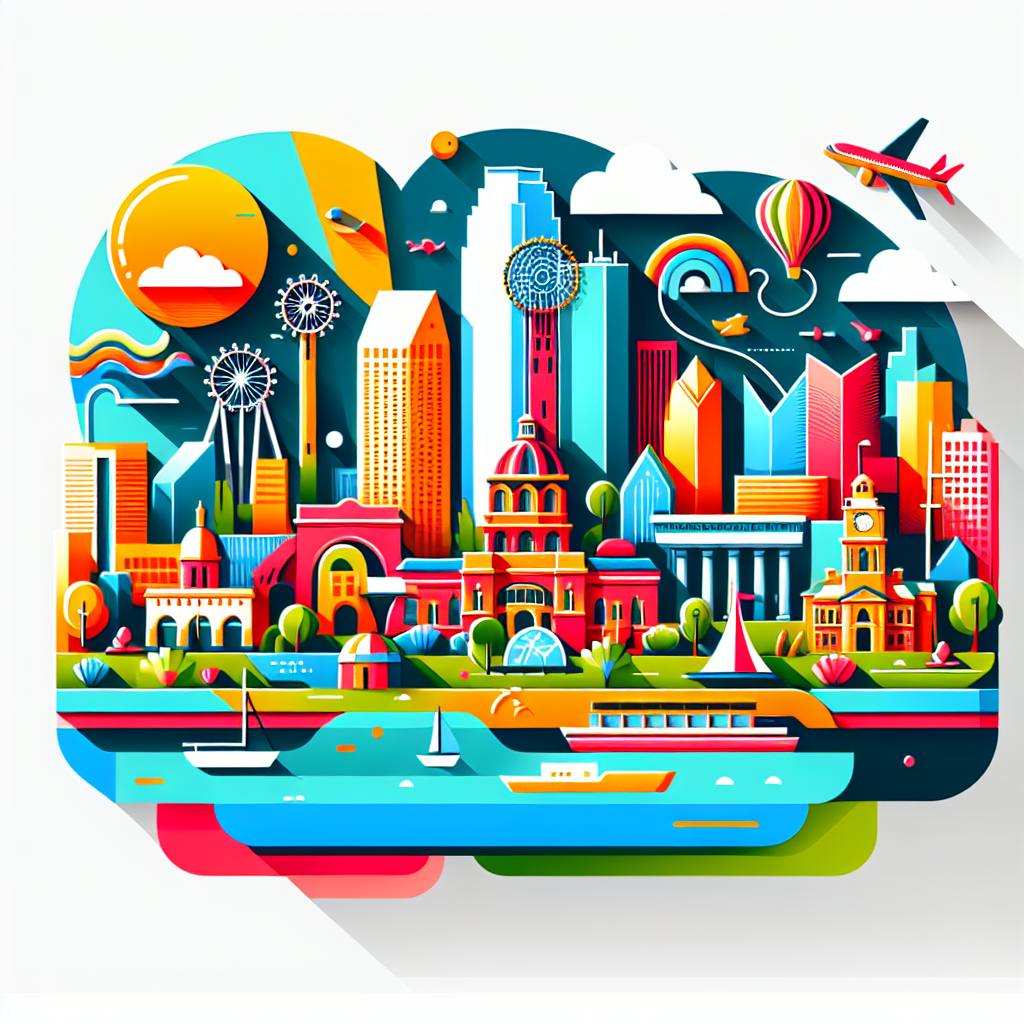

In [5]:
image = artist("Dallas, Texas")
display(image)

### Audio ###

Function that generates Audio - need to look into this, may require additional installs - See Ed donner's work

In [24]:
from IPython.display import Audio
import tempfile
import time

In [27]:
def talker(text):
    # Create a temporary MP3 file
    with tempfile.NamedTemporaryFile(suffix=".mp3", delete=True) as tmp:
        tmp_path = tmp.name

    # Use streaming-compatible version of the API call
    with openai.audio.speech.with_streaming_response.create(
        model="tts-1",
        voice="coral",
        input=text
    ) as response:
        with open(tmp_path, "wb") as f:
            for chunk in response.iter_bytes():
                f.write(chunk)

    # Play audio in notebook
    audio = Audio(filename=tmp_path, autoplay=True)
    display(audio)

    # Give browser time to start playback before deleting
    time.sleep(1.5)
    os.remove(tmp_path)

In [28]:
talker("Hi there, I am an AI generated voice")

### Agent Framework ###
Agentic AI is simply an umbrella team that refers to using LLMs for tools or tasks.

In [ ]:
MODEL = 'gpt-4o-mini'
ticket_prices = {"london":"$799","paris":"$899","tokyo":"$1400","berlin":"$499"}
system_message = """
You are a helpful assistant for an Airline called FlightAI.
Give short, courteous answers, no more than 1-2 sentences.
Always be accurate.  If you don't know the answer say 'I'm unsure'."""

def get_ticket_price(destination_city):
    print(f"Tool get_ticket_price called for {destination_city}")
    city=destination_city.lower()
    return ticket_prices.get(city,"Unknown")
#Need a dictionary structure for tools

price_function = {
    "name":"get_ticket_price",
    "description":"Get the price of a roundtrip ticket to a destination city.  Call tihs whenever you need to know the ticket price if a customer asks for a price to a city",
    "parameters":{
        "type":"object",
        "properties":{
        "destination_city":{
            "type":"string",
            "description":"The city that the customer wants to travel to"
            }
        },
        "required":["destination_city"],
        "additionalProperties":False
    }
}
tools = [{"type":"function","function":price_function}]

def handle_tool_call(message):
    tool_call = message.tool_calls[0]
    arguments = json.loads(tool_call.function.arguments) # tells us what parameters model has chosen - comes back as json
    city = arguments.get('destination_city') # json comes back with dictionary
    price = get_ticket_price(city) # then call function to get price
    # Response as message
    response = {
        "role":"tool",
        "content":json.dumps({"destination_city":city,"price":price}),
        "tool_call_id": message.tool_calls[0].id
    }
    return response, city 

def chat(message,history):
    image = None
    conversation = [{"role":"system","content":system_message}]
    for human, assistant in history:
        conversation.append({"role":"user","content":human})
        conversation.append({"role":"assistant","content":assistant})
    conversation.append({"role":"user","content":message})
    response = openai.chat.completions.create(model=MODEL, messages = conversation, tools = tools)

    if response.choices[0].finish_reason == "tool_calls":
        message = tool_call = response.choices[0].message
        response, city = handle_tool_call(message)
        conversation.append(message)
        conversation.append(response)
        image = artist(city) # if model uses tool - also generate an image of city being looked up
        response = openai.chat.completions.create(model=MODEL, messages = conversation)
    
    reply = response.choices[0].message.content
    talker(reply) # once we get reponse, speak response
    return reply,image

In [34]:
# Let's go outside normal chat interface 

with gr.Blocks() as ui:
    with gr.Row():
        chatbot = gr.Chatbot(height=500)
        image_output = gr.Image(height=500)
    with gr.Row():
        msg = gr.Textbox(label= "Chat with our AI Assistant")
    with gr.Row():
        clear = gr.Button("clear")
        
    def user(user_message,history):
        return "", history + [[user_message,None]]
    
    def bot(history):
        user_message = history[-1][0]
        bot_message, image = chat(user_message, history[:-1])
        history[-1][1] = bot_message
        return history, image
    
    msg.submit(user, [msg,chatbot], [msg,chatbot], queue=False).then(
        bot, chatbot, [chatbot, image_output]
    )
    clear.click(lambda: None, None, chatbot, queue = False)
    
ui.launch()

C:\Users\webbe\AppData\Local\Temp\ipykernel_20528\2461341807.py:5: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot = gr.Chatbot(height=500)


* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.
